In [85]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
from skimage import filters, color
import os
import cv2
import random
import tqdm.auto as tqdm
from functools import partial


In [ ]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

### MEDIDAS

In [49]:
a1 = np.array([[0,0,0,0,0],[0,1,1,0,0],[0,1,1,0,0],[0,0,0,0,0]])
a2 = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,1,1,0],[0,0,1,1,0]])

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# axs[0].imshow(a1)
# axs[1].imshow(a2)
# plt.show()

def image_covering(image, mask):
    """
    This function computes the covering of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    union = np.sum(np.where(image + mask > 0, 1, 0))
    return intersection / union

def image_matching(image, mask):
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

# def image_quality(image, mask):
#     """
#     This function computes the quality of the image by the mask
#     """
#     return image_covering(image, mask) * image_matching(image, mask)

#print(image_covering(a1, a2))

### SEGMENTADORES

In [90]:

class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            print(str(self))
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, desc="Processing", unit="operation",disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                plt.title(operation.__name__)
                plt.imshow(img)
                plt.show()
        return img


def otsu_threshold(image):
    """
    This function computes the Otsu threshold of the image

    returns the binary image
    """
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def kmeans_segmentation(image, k = 5):
    """
    
    """       
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    # then perform k-means clustering with number of clusters defined as 3
    #also random centres are initially choosed for k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image



def print_metrics(binary):
    cleaned = morphology.remove_small_objects(binary, min_size=200) 

    # Label the image (identify separate objects)
    labels = measure.label(cleaned)

    # Find the largest object
    largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Create a mask of the largest object (the pool)
    pool_mask = labels == largest_object

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]

    area = prop.area  
    perimeter = prop.perimeter  

    # Eccentricity of the ellipse equivalent to the region. This is the ratio of the distance between the foci of the ellipse 
    # and its major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
    eccentricity = prop.eccentricity

    equivalent_diameter = prop.equivalent_diameter  # in pixels

    print( "Area: ", area)
    print( "Perimeter: ", perimeter)
    print( "Eccentricity: ", eccentricity)
    print( "Equivalent Diameter: ", equivalent_diameter)

    

def display_image_mask(image, mask):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].matshow(image)
    axs[1].matshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()



imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = color.rgb2gray(np.array(imag))

pipe = pipeline()
pipe.add_operation(partial(kmeans_segmentation, k=3))
pipe.add_operation(otsu_threshold)
binary = pipe.apply(imag, False)
display_image_mask(image_rgb, binary)


pipe2 = pipeline()
pipe2.add_operation(otsu_threshold)
binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)




AttributeError: 'functools.partial' object has no attribute '__name__'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


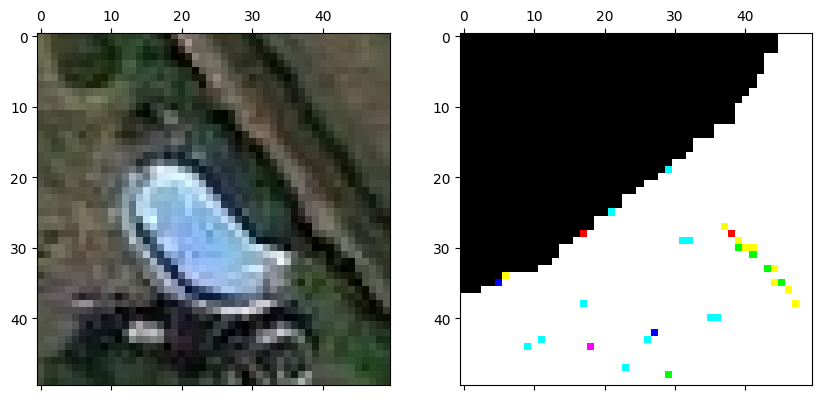

In [10]:
from sklearn.feature_extraction import image
import numpy as np
import os 
import matplotlib.pyplot as plt 

DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')


img = plt.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
mask = img.astype(bool)
graph = image.img_to_graph(img, mask=mask)


graph.data = np.exp(-graph.data / graph.data.std())

import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()